In [2]:
import json
import numpy as np
import torch
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
import time

#torch.set_default_device('cuda:0')
#torch.cuda.is_available()

In [3]:
class MyStaticDatasetLoader(object):
    def __init__(self):
        self._read_web_data()

    def _read_web_data(self):
        with open('../data/graphs/grafo_correlazione_0.2.json') as f:
            self._dataset = json.load(f)

    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        self._edge_weights = np.array(self._dataset["edge_weights"])

    def _get_node_ids(self):
        self._node_ids = np.array(self._dataset["node_ids"])
    
    def _get_targets_and_features(self):
        stacked_target = np.array(self._dataset["series"])
        self.scale = []
        for i in range(24):
            self.scale.append(max(stacked_target[:,i]))
        self.scale = np.array(self.scale)
        self.mu = np.mean(stacked_target, axis=0)
        self.sigma = np.std(stacked_target, axis=0)
        standardized_target = (stacked_target - self.mu) / (self.sigma + 10 ** -10)
        #standardized_target = stacked_target/self.scale
        self.features = [
            standardized_target[i : i + self.lags, :].T
            for i in range(standardized_target.shape[0] - self.lags)
        ]
        self.targets = [
            standardized_target[i + self.lags, :].T
            for i in range(standardized_target.shape[0] - self.lags)
        ]

    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_node_ids()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        return dataset

lags = 3
loader = MyStaticDatasetLoader()
dataset = loader.get_dataset(lags=lags)
dataset[1]

Data(x=[24, 3], edge_index=[2, 540], edge_attr=[540], y=[24])

In [21]:
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch_geometric_temporal.nn.recurrent import TGCN
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)
#train_dataset[6420]
descale(train_dataset[0].x.T[2].detach().cpu().numpy(), sigma, mu, scale)

array([25.53999984, 20.99999992, 21.0000001 , 21.04000033, 21.03999996,
       28.72999991, 31.32000026, 33.24999963, 33.85999947, 35.99000026,
       60.38000033, 51.14000009, 43.06000186, 31.59999923, 31.54000058,
       32.32999983, 46.25999845, 63.74000132, 35.42000127, 34.65999849,
       33.86000051, 33.18000077, 30.86999931, 21.62999961])

In [20]:
train_dataset[0].x.T[2]

tensor([-0.2301, -0.3505, -0.3270, -0.2872, -0.2789, -0.0660, -0.1894, -0.2009,
        -0.2792, -0.2931, -0.1382, -0.2513, -0.2929, -0.3772, -0.3656, -0.3649,
        -0.3345, -0.2680, -0.3489, -0.3387, -0.3452, -0.3606, -0.2859, -0.4491])

In [8]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from updated_models.TGCN_w import TGCN_W
out_channels=5

In [9]:
class GNN(torch.nn.Module):
    def __init__(self, node_features):
        super(GNN, self).__init__()
        self.conv = TGCN_W(in_channels=node_features, out_channels=out_channels, num_layers=5)
        #self.linear1 = torch.nn.Linear(50, 30)
        #self.drop = torch.Dropout(0.2)
        self.linear2 = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_weight, H):
        H = self.conv(x, edge_index, edge_weight, H)
        h = H
        #h = self.linear1(h)
        h = F.relu(h)
        h = self.linear2(h)
        #h = F.relu(h)
        return h, H

In [10]:
sigma = loader.sigma
mu = loader.mu
scale = loader.scale
def descale(output, sigma, mu, scale):
    return output* sigma + mu#*scale

  Epoch 1/100
Training loss:  1.0522931
  Epoch 2/100
Training loss:  1.0250454
  Epoch 3/100
Training loss:  1.0082761
  Epoch 4/100
Training loss:  1.0028011
  Epoch 5/100
Training loss:  1.0024308
  Epoch 6/100
Training loss:  0.9878734
  Epoch 7/100
Training loss:  0.96195894
  Epoch 8/100
Training loss:  0.9329977
  Epoch 9/100
Training loss:  0.9094449
  Epoch 10/100
Training loss:  0.8785913
  Epoch 11/100
Training loss:  0.8639683
  Epoch 12/100
Training loss:  0.86994517
  Epoch 13/100
Training loss:  0.8760727
  Epoch 14/100
Training loss:  0.8748891
  Epoch 15/100
Training loss:  0.8682333
  Epoch 16/100
Training loss:  0.8586865
  Epoch 17/100
Training loss:  0.8470199
  Epoch 18/100
Training loss:  0.83802766
  Epoch 19/100
Training loss:  0.8351897
  Epoch 20/100
Training loss:  0.83121395
  Epoch 21/100
Training loss:  0.82682854
  Epoch 22/100
Training loss:  0.82038975
  Epoch 23/100
Training loss:  0.814419
  Epoch 24/100
Training loss:  0.8100875
  Epoch 25/100
Train

Text(0.5, 0, 'epoch')

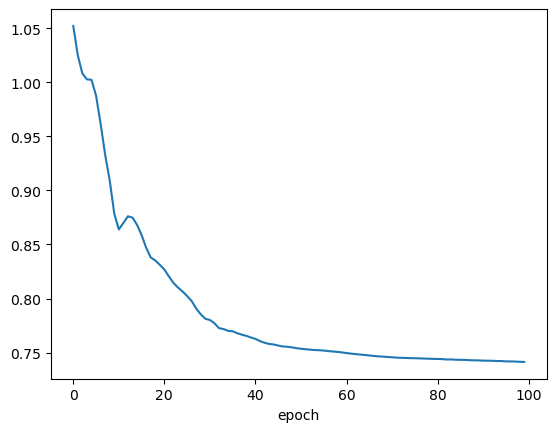

In [38]:
model = GNN(node_features = lags)

#model = model.to('cuda')
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.035) #0.1 dcrnn #0.05 gru
loss_fn = F.mse_loss

start_time = time.perf_counter() # Start timer
num_epochs = 100
losses = []
outputs = []  #
targets = []  #
for epoch in range(num_epochs):
    loss = 0
    epoch_outputs = []  #
    epoch_targets = []  #
    H = torch.zeros(24,out_channels)
    print("  Epoch %d/%d" % (epoch+1,num_epochs))
    for time_step, snapshot in enumerate(train_dataset):
        #snapshot.to('cuda')
        output, H = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, H=H)
        loss = loss + loss_fn(output.T[0], snapshot.y)
        epoch_outputs.append(descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale))  #
        epoch_targets.append(descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale))   #
        
    loss = loss/(time_step+1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    losses.append(loss.detach().cpu().numpy())
    outputs.append(epoch_outputs)  #
    targets.append(epoch_targets)  #
    print('Training loss: ', losses[-1])

end_time = time.perf_counter() # End timer
print("Elapsed time: ", end_time - start_time) # Calculate elapsed time
 
plt.plot(losses)
plt.xlabel("epoch")

In [20]:
outputs_hourly = []
targets_hourly = []
for j in range(24):
    outhourlist = [outputs[-1][i][j] for i in range(len(outputs[-1]))]
    tarhourlist = [targets[-1][i][j] for i in range(len(outputs[-1]))]
    outputs_hourly.append(outhourlist)
    targets_hourly.append(tarhourlist)

In [21]:
#Test set
test_outputs = []  #
test_targets = []  #
for time_step, snapshot in enumerate(test_dataset):
    #snapshot.to('cuda')
    output, H = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, H=H)
    test_output = descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale)
    test_snapshot = descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale)
    test_outputs.append(test_output)  #
    test_targets.append(test_snapshot)   #

In [22]:
outputs_hourly_test = []
targets_hourly_test = []
for j in range(24):
    outhourlist = [test_outputs[i][j] for i in range(len(test_outputs))]
    tarhourlist = [test_targets[i][j] for i in range(len(test_outputs))]
    outputs_hourly_test.append(outhourlist)
    targets_hourly_test.append(tarhourlist)

In [23]:
mse_test = []
for j in range(24):
    sqdiff = [(a - b)**2 for a, b in zip(targets_hourly_test[j], outputs_hourly_test[j])]
    mse_test.append(np.mean(sqdiff))
mse_test

[853.7307818720202,
 442.93208727760117,
 248.8693178278287,
 424.5387022365401,
 526.2709981986711,
 1164.8070641012198,
 3676.8497528651183,
 5367.570894494241,
 6311.810682174481,
 8104.133026126796,
 10814.475260417254,
 12017.551347966286,
 10536.906669859962,
 13892.290296883877,
 14260.948777103116,
 15662.854663923956,
 20871.797981056712,
 23293.02033017135,
 16111.799423017112,
 12039.63905070021,
 7876.278389633535,
 4316.099942727906,
 2065.6799768129586,
 1706.2242304095332]

In [24]:
np.mean(mse_test)

8024.461651994096

In [25]:
mae_test = []
for j in range(24):
    absdiff = [abs(a - b) for a, b in zip(targets_hourly_test[j], outputs_hourly_test[j])]
    mae_test.append(np.mean(absdiff))
mae_test

[8.46892857866516,
 7.373829882521767,
 7.960886682205795,
 8.867220903942389,
 9.185834235132734,
 10.292447157162728,
 19.18100122528023,
 24.480243691223883,
 28.976369757323873,
 34.36658432012465,
 45.45339407310468,
 50.91245062583942,
 46.49637598056084,
 52.63217151861416,
 51.63150519565422,
 55.37267533655281,
 70.71451849391555,
 79.14651857718059,
 56.26684232964519,
 45.80281982181594,
 37.02330378076749,
 28.749200648499556,
 14.21450520964272,
 14.024608815943253]

In [26]:
np.mean(mae_test)

33.649759868388315

In [27]:
#unisco train e test
outputs_merged = [l1 + l2 for l1, l2 in zip(outputs_hourly, outputs_hourly_test)]
targets_merged = [l1 + l2 for l1, l2 in zip(targets_hourly, targets_hourly_test)]

In [28]:
list_ids = loader._node_ids
dict = list_ids.item()
inverse_dict = {value: key for key, value in dict.items()}
inverse_dict.get(0)

'00:00'

In [29]:
name_model = model.conv.__class__.__name__[:4]
name_model

'TGCN'

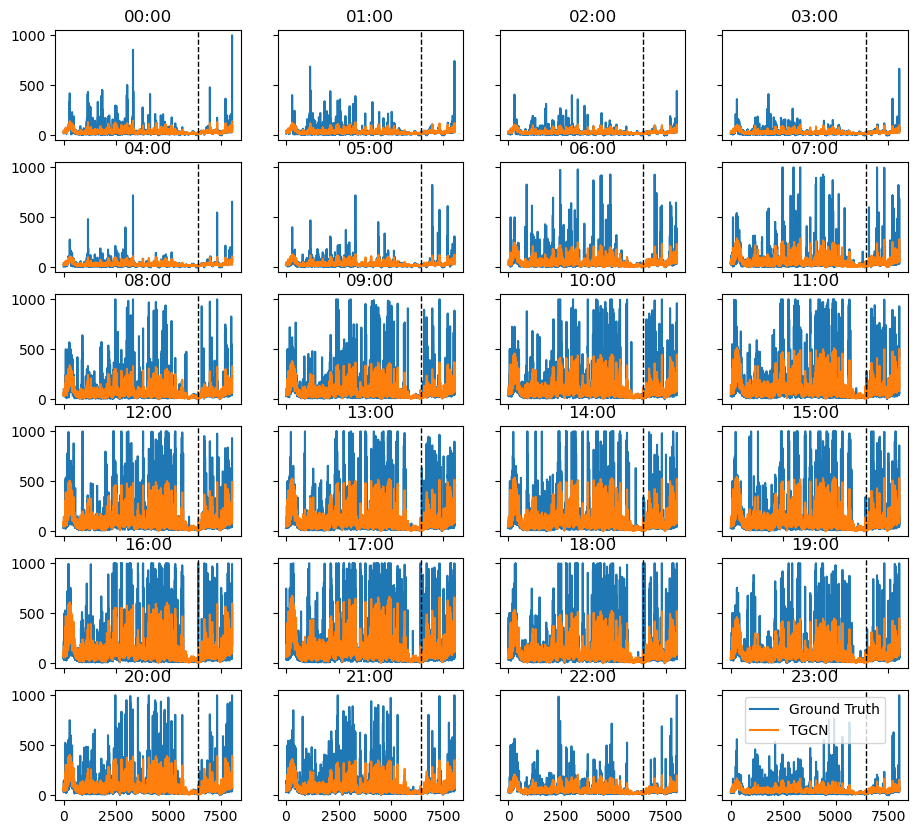

In [30]:
fig, axs = plt.subplots(6, 4, figsize=(11, 10), sharey=True, sharex=True)

# Iteriamo sulla lista delle matrici e le visualizziamo in subplots
for i in range(6):
    axs[i,0].plot(targets_merged[i*4], label="Ground Truth")
    axs[i,0].plot(outputs_merged[i*4], label=name_model)
    axs[i,0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,1].plot(targets_merged[i*4+1], label="Ground Truth")
    axs[i,1].plot(outputs_merged[i*4+1], label=name_model)
    axs[i,1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,2].plot(targets_merged[i*4+2], label="Ground Truth")
    axs[i,2].plot(outputs_merged[i*4+2], label=name_model)
    axs[i,2].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,3].plot(targets_merged[i*4+3], label="Ground Truth")
    axs[i,3].plot(outputs_merged[i*4+3], label=name_model)
    axs[i,3].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,0].set_title(inverse_dict[i*4])  # Titolo del subplot
    axs[i,1].set_title(inverse_dict[i*4+1])
    axs[i,2].set_title(inverse_dict[i*4+2])
    axs[i,3].set_title(inverse_dict[i*4+3])
    #axs[i].axis('off')  # Nasconde gli assi
plt.legend()
plt.savefig('../plot/'+name_model.lower()+'plot.jpg', format='jpg')
# Mostriamo la figura con tutti i subplot
plt.show()

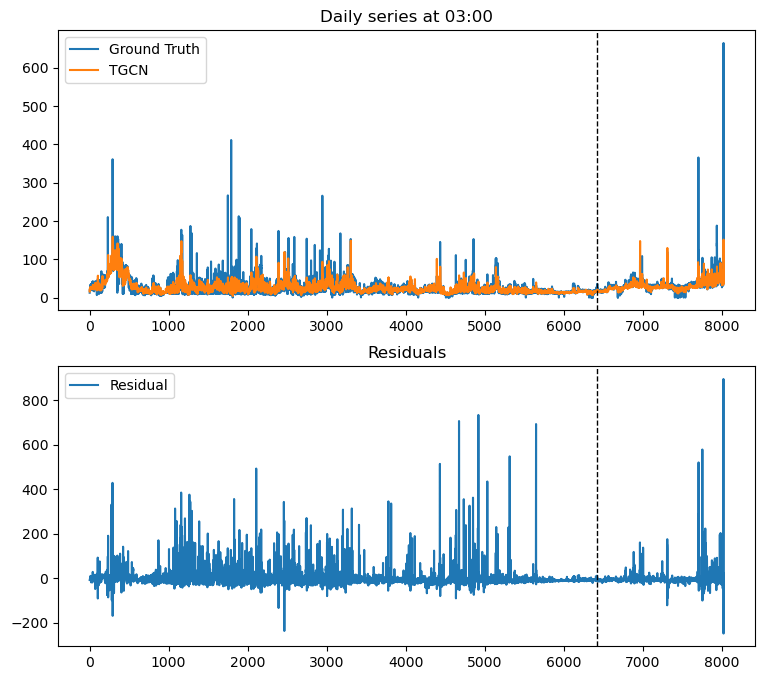

In [23]:
hour = 3

diff = [a - b for a, b in zip(targets_merged[j], outputs_merged[j])]
fig, axs = plt.subplots(2, 1, figsize=(9, 8))
axs[0].plot(targets_merged[hour], label="Ground Truth")
axs[0].plot(outputs_merged[hour], label=name_model)
axs[0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0].legend()
axs[0].set_title("Daily series at "+inverse_dict[hour])
axs[1].plot(diff, label="Residual")
axs[1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1].legend()
axs[1].set_title("Residuals")
plt.show()

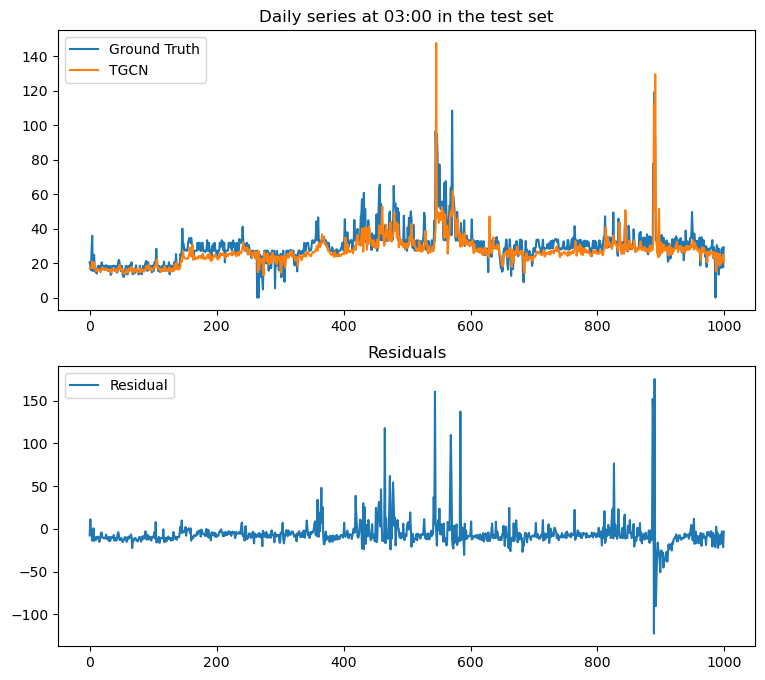

In [24]:
hour = 3

diff = [a - b for a, b in zip(targets_hourly_test[j], outputs_hourly_test[j])]
fig, axs = plt.subplots(2, 1, figsize=(9, 8))
axs[0].plot(targets_hourly_test[hour][:1000], label="Ground Truth")
axs[0].plot(outputs_hourly_test[hour][:1000], label=name_model)
axs[0].legend()
axs[0].set_title("Daily series at "+inverse_dict[hour]+" in the test set")
axs[1].plot(diff[:1000], label="Residual")
axs[1].legend()
axs[1].set_title("Residuals")
plt.show()

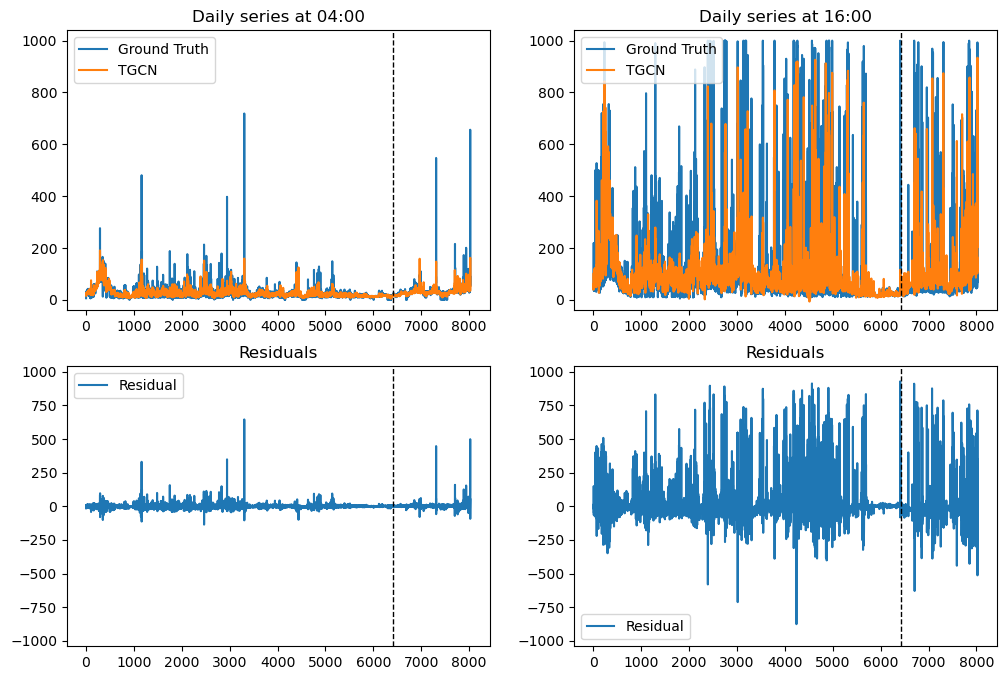

In [25]:
hour1 = 4
hour2 = 16

diff1 = [a - b for a, b in zip(targets_merged[hour1], outputs_merged[hour1])]
diff2 = [a - b for a, b in zip(targets_merged[hour2], outputs_merged[hour2])]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(targets_merged[hour1], label="Ground Truth")
axs[0,0].plot(outputs_merged[hour1], label=name_model)
axs[0,0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0,0].legend()
axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1])
axs[1,0].plot(diff1, label="Residual")
axs[1,0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1,0].legend()
axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_merged[hour2], label="Ground Truth")
axs[0,1].plot(outputs_merged[hour2], label=name_model)
axs[0,1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0,1].legend()
axs[0,1].set_ylim(-40,1040)
axs[0,1].set_title("Daily series at "+inverse_dict[hour2])
axs[1,1].plot(diff2, label="Residual")
axs[1,1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1,1].legend()
axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('../plot/focus'+name_model.lower()+'.jpg', format='jpg')
plt.show()

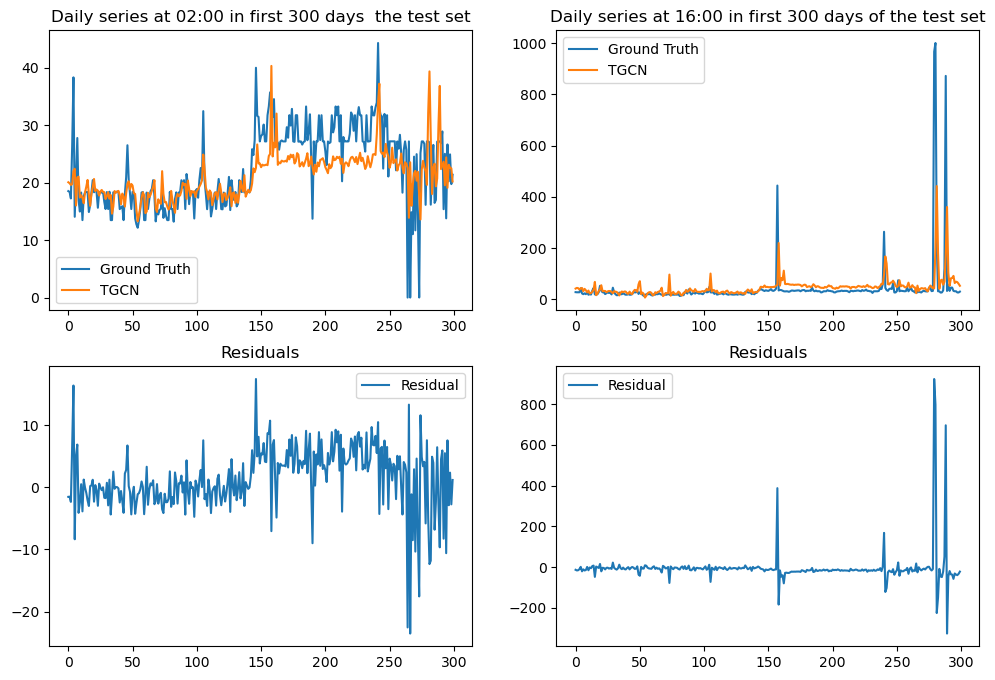

In [31]:
hour1 = 2
hour2 = 16
fd = 300

diff1 = [a - b for a, b in zip(targets_hourly_test[hour1], outputs_hourly_test[hour1])]
diff2 = [a - b for a, b in zip(targets_hourly_test[hour2], outputs_hourly_test[hour2])]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(targets_hourly_test[hour1][:fd], label="Ground Truth")
axs[0,0].plot(outputs_hourly_test[hour1][:fd], label=name_model)
axs[0,0].legend()
#axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1]+" in first "+str(fd)+" days  the test set")
axs[1,0].plot(diff1[:fd], label="Residual")
axs[1,0].legend()
#axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_hourly_test[hour2][:fd], label="Ground Truth")
axs[0,1].plot(outputs_hourly_test[hour2][:fd], label=name_model)
axs[0,1].legend()
#axs[0,1].set_ylim(-40,1040)
axs[0,1].set_title("Daily series at "+inverse_dict[hour2]+" in first "+str(fd)+" days of the test set")
axs[1,1].plot(diff2[:fd], label="Residual")
axs[1,1].legend()
#axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('../plot/focustest'+name_model.lower()+'.jpg', format='jpg')
plt.show()

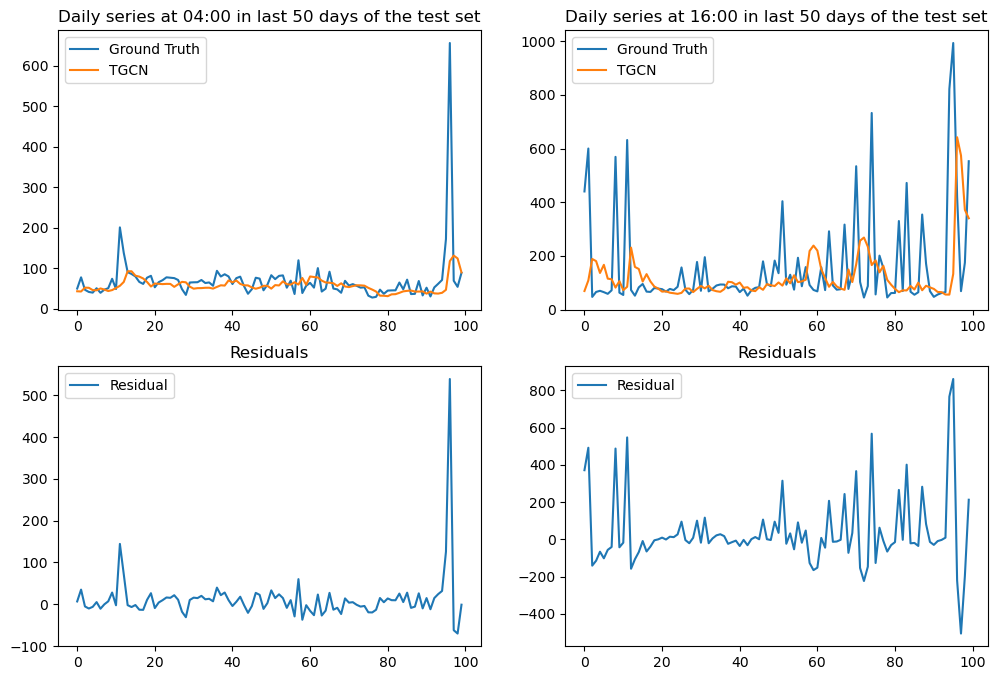

In [23]:
#o uno o l'altro
hour1 = 4
hour2 = 16
fd=100

diff1 = [a - b for a, b in zip(targets_hourly_test[hour1], outputs_hourly_test[hour1])]
diff2 = [a - b for a, b in zip(targets_hourly_test[hour2], outputs_hourly_test[hour2])]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(targets_hourly_test[hour1][-fd:], label="Ground Truth")
axs[0,0].plot(outputs_hourly_test[hour1][-fd:], label=name_model)
axs[0,0].legend()
#axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1]+" in last 50 days of the test set")#"+str(fd)+"
axs[1,0].plot(diff1[-fd:], label="Residual")
axs[1,0].legend()
#axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_hourly_test[hour2][-fd:], label="Ground Truth")
axs[0,1].plot(outputs_hourly_test[hour2][-fd:], label=name_model)
axs[0,1].legend()
#axs[0,1].set_ylim(-40,1040)
axs[0,1].set_title("Daily series at "+inverse_dict[hour2]+" in last 50 days of the test set")#"+str(fd)+"
axs[1,1].plot(diff2[-fd:], label="Residual")
axs[1,1].legend()
#axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('plot/focustestdyn'+name_model.lower()+'.jpg', format='jpg')
plt.show()

In [39]:
df_compare = pd.DataFrame({'a': outputs_hourly_test[hour1][-fd:], 'b': outputs_hourly_test[hour2][-fd:], 'c': diff1[-fd:], 'd': diff2[-fd:]})

In [40]:
# df_compare.to_csv('plot/compare/compare_TGCN.csv', index=False)

In [24]:
output_list = [outputs_hourly_test[i] for i in range(24)]
target_list = [targets_hourly_test[i] for i in range(24)]

In [26]:
import pandas as pd
dit_o_test = {}
dit_t_test = {}
for i, lista in enumerate(output_list, start=1):
    nome_colonna = f'Hour {i}'
    dit_o_test[nome_colonna] = lista
    
for i, lista in enumerate(target_list, start=1):
    nome_colonna = f'Hour {i}'
    dit_t_test[nome_colonna] = lista
    
df_t_test = pd.DataFrame(dit_t_test)
df_o_test = pd.DataFrame(dit_o_test)
df_t_test

,Hour 1,Hour 2,Hour 3,Hour 4,Hour 5,Hour 6,Hour 7,Hour 8,Hour 9,Hour 10,...,Hour 15,Hour 16,Hour 17,Hour 18,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24
0,21.610000,18.960000,18.530000,20.420000,20.430000,20.430000,20.980001,20.170001,20.510001,21.630000,...,38.950000,102.870000,28.320001,27.770000,27.200002,27.730001,25.910000,27.199999,27.330000,21.650000
1,20.260000,18.400000,18.390000,18.390000,18.390000,18.390000,18.390000,20.419999,20.079999,21.330001,...,27.770000,27.769999,27.770002,36.360001,116.810000,30.620001,27.770001,27.060001,20.700000,41.840000
2,32.690000,19.160000,17.250000,15.860000,15.490000,23.650000,24.770001,16.680000,18.280000,18.950000,...,27.789999,27.769999,27.670002,21.210002,27.659999,27.739999,23.380001,28.190000,34.580000,26.060000
3,28.170000,31.180000,26.350000,26.820000,23.220000,25.550000,27.870000,21.149999,21.419999,26.340000,...,24.770000,26.639999,27.770002,27.790002,28.350002,27.770000,20.600001,27.790000,27.740001,28.880000
4,27.870000,38.430000,38.330000,35.810000,18.390000,18.390000,18.390000,20.529999,25.270000,26.420001,...,30.070000,30.580001,43.539999,39.680001,40.810002,27.249999,21.489999,19.530000,18.080001,17.649999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601,281.830004,413.119987,442.569990,160.640003,172.449996,172.449997,328.400009,371.259994,239.649991,749.219978,...,985.019983,858.330022,993.159968,999.960043,999.969980,999.980008,999.990050,999.989970,999.990045,999.990016
1602,999.990018,742.590005,228.809993,664.920018,656.349977,308.950003,387.859991,687.099984,154.780000,95.870000,...,284.360000,113.789999,421.319999,646.740007,371.999997,148.609998,67.970000,45.689999,38.090000,41.920000
1603,44.459999,60.620000,63.579999,55.040001,69.260000,84.350000,75.569999,63.150000,124.190001,887.229992,...,69.660000,76.230000,68.570001,52.909998,39.060000,45.989999,48.569999,45.070000,42.020000,46.060000
1604,42.160000,37.500000,35.100000,42.730000,54.210001,55.260001,58.150000,64.890000,70.380000,81.650000,...,71.150000,75.980000,174.650002,472.509997,102.510000,153.980001,82.010000,84.940000,74.680000,74.619999


In [28]:
train_size = 6346
df_var = pd.read_csv('errors/var_test.csv')
df_var = df_var.iloc[train_size:,:]
df_var

,Hour0,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,...,Hour14,Hour15,Hour16,Hour17,Hour18,Hour19,Hour20,Hour21,Hour22,Hour23
6346,19.159501,16.545452,15.435806,15.434062,15.821917,17.500707,19.543061,21.757306,21.375836,25.000655,...,36.276089,42.327074,39.605474,33.895859,34.181624,36.024670,32.734106,25.183251,32.616649,30.643083
6347,19.824034,19.064482,17.936807,17.628670,16.953797,18.306510,26.854590,24.371825,25.737492,32.800009,...,45.929034,45.198097,43.096671,36.160456,25.926308,28.421699,33.853490,31.042379,27.303287,29.430383
6348,19.483434,20.019377,19.182433,17.759780,18.929275,23.361110,26.614658,29.052504,31.663155,33.741091,...,70.299200,63.717740,63.299664,79.440539,54.126233,36.981172,37.846023,37.079804,31.336791,26.608880
6349,17.844619,18.366806,16.798577,17.697053,18.093111,21.501075,30.754682,38.898842,36.537243,34.462548,...,58.225020,51.991729,66.156734,82.090342,54.581137,53.483321,47.933341,51.331986,30.572403,32.334367
6350,18.799345,17.179372,17.123379,16.906144,16.846210,19.092796,21.703157,25.250977,28.015278,27.772575,...,38.159226,37.910446,37.995477,52.720509,30.486497,27.210269,23.276266,30.528560,25.157034,24.824975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7929,206.088780,173.763203,120.895498,102.919754,114.261082,131.001157,171.574299,172.217197,209.658773,235.896462,...,202.958956,245.575950,400.844548,571.145978,409.121070,357.329937,286.556401,203.979643,112.124211,179.140880
7930,379.896297,332.360171,232.336639,208.922013,208.594982,231.881673,418.423308,421.670933,530.896387,843.136144,...,822.799332,865.595379,909.544470,957.839754,788.808150,701.185363,486.660659,529.741317,376.395707,360.837199
7931,166.748602,250.225494,236.764619,215.536784,239.096676,217.190367,106.668365,288.176787,267.621224,94.128258,...,509.403449,360.490891,508.964608,641.653917,558.474401,504.924242,338.314800,345.964424,288.583145,202.075642
7932,140.669110,47.407865,142.531037,105.792675,118.469095,108.746925,202.478968,219.763448,246.907375,204.972438,...,50.319595,45.513923,205.607561,234.568277,39.865024,78.005328,197.113672,77.968547,13.761617,53.219885


<Axes: >

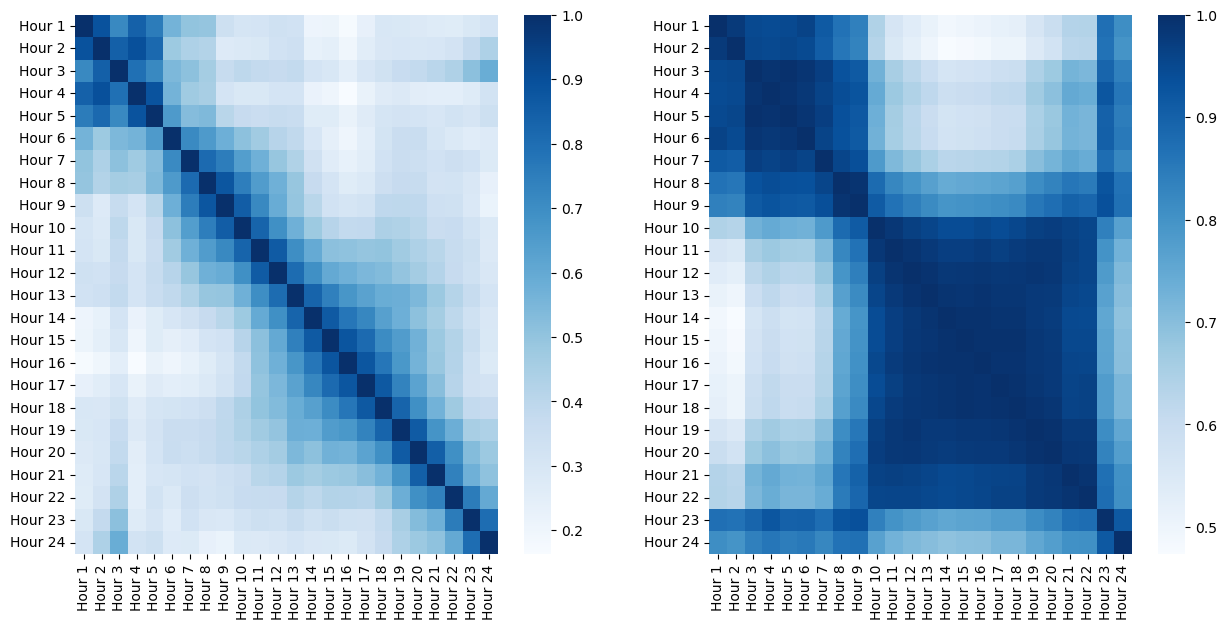

In [31]:
output_model = df_o_test#df_var
target_ = df_t_test#df_o_test
import seaborn as sb
fig, ax = plt.subplots(1,2, figsize=(15,7))
sb.heatmap(target_.corr(), cmap="Blues", annot=False, cbar=True, ax=ax[0])
sb.heatmap(output_model.corr(), cmap="Blues", annot=False, cbar=True, ax=ax[1])

In [15]:
mse_train = []
for j in range(24):
    sqdiff = [(a - b)**2 for a, b in zip(targets_hourly[j], outputs_hourly[j])]
    mse_train.append(np.mean(sqdiff))
mse_train

[835.9534657730626,
 659.9670514312055,
 349.4343654078038,
 270.3690054466741,
 341.4906135123629,
 524.8078831788783,
 3722.3700254595,
 4418.379412153006,
 5987.005649346895,
 8116.790888152841,
 11711.676835583477,
 15350.077130770513,
 15679.139791856067,
 17476.55624182664,
 18346.264655777064,
 18533.858554271334,
 21897.787177536295,
 28919.902235674865,
 17580.38242750955,
 13140.353030194505,
 10018.1979277375,
 8014.404290230558,
 2133.0752472618283,
 1893.4670533155142]

In [16]:
mae_train = []
for j in range(24):
    absdiff = [abs(a - b) for a, b in zip(targets_hourly[j], outputs_hourly[j])]
    mae_train.append(np.mean(absdiff))
mae_train

[12.070478231110782,
 11.200432080427916,
 9.43372733783733,
 8.85750474826579,
 9.059770385067035,
 10.737416820816584,
 24.909876845404728,
 29.916110268227563,
 35.458591813082585,
 39.18132253626634,
 48.85241955336257,
 56.47393826259899,
 55.96968306746834,
 59.631291408535255,
 60.32472818224435,
 61.789117926225885,
 70.26534651231252,
 82.79455025210274,
 60.125701752806066,
 51.69828067939999,
 45.52377229271484,
 40.580922410485215,
 21.05761900165262,
 20.49680097284403]

In [17]:
mse_train_prunedTGCN = mse_train
mse_test_prunedTGCN = mse_test

In [18]:
mae_train_prunedTGCN = mae_train
mae_test_prunedTGCN = mae_test

In [19]:
mse_train_prunedTGCN = [round(v, 1) for v in mse_train_prunedTGCN]
mse_test_prunedTGCN = [round(v, 1) for v in mse_test_prunedTGCN]

In [20]:
mae_train_prunedTGCN = [round(v, 1) for v in mae_train_prunedTGCN]
mae_test_prunedTGCN = [round(v, 1) for v in mae_test_prunedTGCN]

In [21]:
np.mean(mse_train_prunedTGCN)

9413.420833333334

In [31]:
np.mean(mae_train_prunedTGCN)

38.608333333333334

In [22]:
np.mean(mse_test_prunedTGCN)

9138.941666666668

In [23]:
np.mean(mae_test_prunedTGCN)

35.074999999999996

In [34]:
import pandas as pd
df_mse = pd.DataFrame({'a': mse_train_prunedTGCN, 'b': mse_test_prunedTGCN, 'c': mae_train_prunedTGCN, 'd': mae_test_prunedTGCN})

# Esportare la tabella in formato LaTeX
latex_table = df_mse.to_latex(index=False)
print(latex_table)

\begin{tabular}{rrrr}
\toprule
      a &       b &    c &    d \\
\midrule
  836.0 &   951.3 & 12.1 & 11.0 \\
  660.0 &   472.2 & 11.2 &  8.3 \\
  349.4 &   261.0 &  9.4 &  7.8 \\
  270.4 &   404.8 &  8.9 &  8.5 \\
  341.5 &   507.0 &  9.1 &  8.8 \\
  524.8 &  1150.5 & 10.7 & 10.3 \\
 3722.4 &  4029.2 & 24.9 & 22.1 \\
 4418.4 &  5489.7 & 29.9 & 27.7 \\
 5987.0 &  6587.5 & 35.5 & 31.4 \\
 8116.8 &  8737.2 & 39.2 & 38.0 \\
11711.7 & 12421.3 & 48.9 & 47.8 \\
15350.1 & 14342.8 & 56.5 & 52.4 \\
15679.1 & 12661.5 & 56.0 & 50.3 \\
17476.6 & 16081.6 & 59.6 & 54.8 \\
18346.3 & 17179.3 & 60.3 & 56.5 \\
18533.9 & 18392.4 & 61.8 & 58.9 \\
21897.8 & 24203.1 & 70.3 & 68.5 \\
28919.9 & 26437.2 & 82.8 & 74.3 \\
17580.4 & 18076.2 & 60.1 & 57.3 \\
13140.4 & 13522.5 & 51.7 & 47.6 \\
10018.2 &  8716.6 & 45.5 & 37.9 \\
 8014.4 &  4809.1 & 40.6 & 28.8 \\
 2133.1 &  2111.3 & 21.1 & 16.6 \\
 1893.5 &  1789.3 & 20.5 & 16.2 \\
\bottomrule
\end{tabular}



In [36]:
df_mse.to_csv('errors/errori_TGCN.csv', index=False)

In [73]:

# Per salvare modello
#model = model.to('cpu')
# torch.save(model.state_dict(), 'models/gnn_TGCN_3_30_0.085.pth')


In [8]:
# Per caricare modello
model = ConvolutionalGCN(node_features = lags)
model.load_state_dict(torch.load('models/gnn_TGCN_3_30_0.085.pth'))
#model = model.to('cuda')
print(model)

{'training': True, '_parameters': OrderedDict({'bias': Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], requires_grad=True)}), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict({'aggr_module': SumAggregation(), 'lin': Linear(3, 30, bias=False)}), 'aggr': 'sum', 'flow': 'source_to_target', 'node_dim': -2, 'decomposed_layers': 1, 'inspector': <torch_geometric.nn.conv.u

In [9]:
#Training set
H = torch.zeros(24,30)
outputs = []  #
targets = []  #
for time_step, snapshot in enumerate(train_dataset):
    #snapshot.to('cuda')
    output, H = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, H=H)
    train_output = descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale)
    train_snapshot = descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale)
    outputs.append(train_output)  #
    targets.append(train_snapshot)   #

In [10]:
outputs_hourly = []
targets_hourly = []
for j in range(24):
    outhourlist = [outputs[i][j] for i in range(len(outputs))]
    tarhourlist = [targets[i][j] for i in range(len(outputs))]
    outputs_hourly.append(outhourlist)
    targets_hourly.append(tarhourlist)